In [2]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from scipy.stats import kurtosis, skew, kstest, spearmanr
# from sklearn.linear_model import LinearRegression as lm

import statsmodels.api as sm

cproj = cartopy.crs.PlateCarree()

## **Covariate time series**

In [3]:
gmst = decode_times(xr.open_dataset("igiss_al_gl_a_4yrlo.nc", decode_times = False)).Ta.sel(time = slice("1950", "2023"))
nino34rel = decode_times(xr.open_dataset("iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023"))
dmi = decode_times(xr.open_dataset("idmi_ersst.nc", decode_times = False))["diff"].sel(time = slice("1950", "2023"))

In [11]:
dmi.dropna("time", "any")

<xarray.DataArray 'diff' (time: 886)>
array([ 0.077526, -0.489441, -0.277684, ...,  0.895426,  1.332367,  1.647908],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2023-10-15
Attributes:
    long_name:  difference of sst and sst
    units:      degree_C

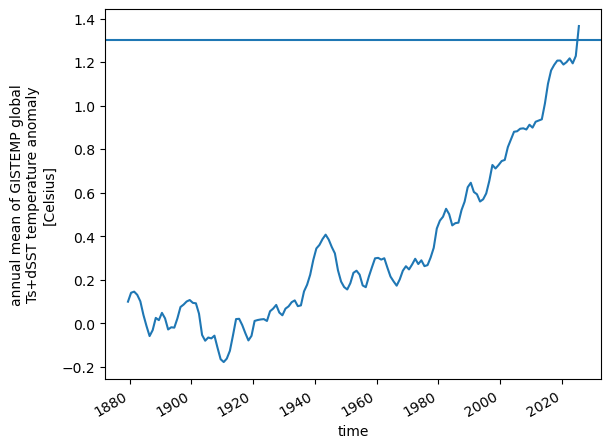

In [13]:
gmst = decode_times(xr.open_dataset("igiss_al_gl_a_4yrlo.nc", decode_times = False)).Ta
gmst = gmst - gmst.sel(time = slice(None, "1918")).mean()
gmst.sel(time = slice(None, "2025")).plot()
plt.axhline(1.3)

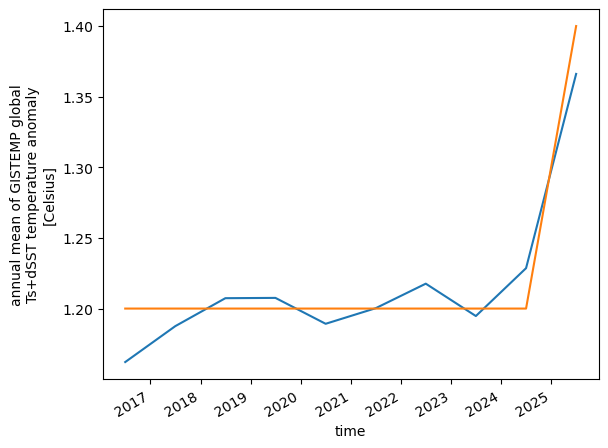

In [14]:
gmst.sel(time = slice(None, "2025")).isel(time = slice(-10,None)).plot()
gmst.sel(time = slice(None, "2025")).round(1).isel(time = slice(-10,None)).plot()

In [15]:
gmst.sel(time = slice(None, "1930")).mean()

<xarray.DataArray 'Ta' ()>
array(0.00724039, dtype=float32)
Attributes:
    long_name:  annual mean of GISTEMP global Ts+dSST temperature anomaly
    units:      Celsius

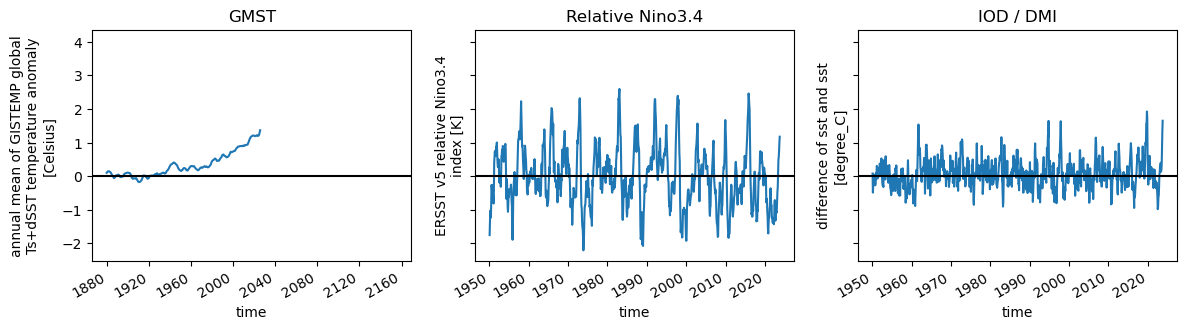

In [16]:
fig, axs = plt.subplots(ncols = 3, figsize = (14,3), dpi = 100, sharey = True)
plt.subplots_adjust(wspace = 0.2)

gmst.plot(ax = axs[0]); axs[0].set_title("GMST")
nino34rel.plot(ax = axs[1]); axs[1].set_title("Relative Nino3.4")
dmi.plot(ax = axs[2]); axs[2].set_title("IOD / DMI")

for ax in axs:
    ax.axhline(0, color = "k")
    
plt.savefig("fig/covariate-timeseries.png")

In [17]:
xr.corr(nino34rel, dmi)

<xarray.DataArray ()>
array(0.25771743)
Attributes:
    long_name:  ERSST v5 relative Nino3.4 index
    units:      K

In [18]:
xr.open_dataset("../../Downloads/iera5_t2m_daily_af_Madagascar_5lan_su.nc")

FileNotFoundError: [Errno 2] No such file or directory: b'/home/clair/Downloads/iera5_t2m_daily_af_Madagascar_5lan_su.nc'

Text(0, 0.5, 'DMI')

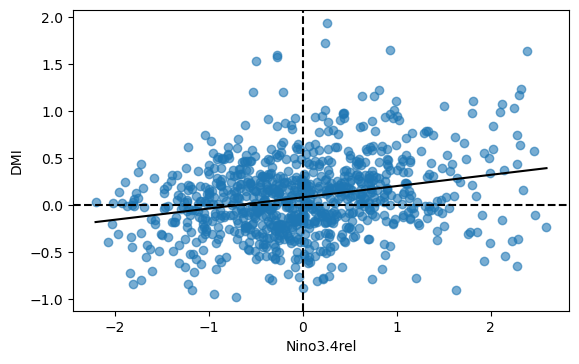

In [31]:
plt.scatter(nino34rel, dmi, alpha = 0.6)
ax = plt.gca()
xyline(nino34rel.dropna("time", "any").values, dmi.dropna("time", "any").values, ax = ax, color = "k")
ax.set_aspect("equal")
ax.axhline(0, color = "k", ls = "--"); ax.axvline(0, color = "k", ls = "--")
ax.set_xlabel("Nino3.4rel"); ax.set_ylabel("DMI")

### **Convert .nc to .csv**

In [4]:
da = decode_times(xr.open_dataset("data/iera5_t2m_daily_af_Madagascar_5lan_su_mean12_anom_30_10_.nc", decode_times = False)).t2m
da = da.assign_coords(time = da.time.dt.year).rename("var", time = "year")
da.to_dataframe().to_csv("data/era5_madagascar_t2m-mean.csv")

In [5]:
da = decode_times(xr.open_dataset("data/iera5_tmax_daily_af_47.54E_-18.91N_n_5lan_su_shift6_max12_7v_anom_30_10_.nc", decode_times = False)).max_tmax
da = da.assign_coords(time = da.time.dt.year).rename("var", time = "year")
da.to_dataframe().to_csv("data/era5_antananarivo_tx7x.csv")

In [6]:
da = decode_times(xr.open_dataset("data/iera5_tmin_daily_af_47.54E_-18.91N_n_5lan_su_shift6_max12_7v_anom_30_10_.nc", decode_times = False)).max_tmin
da = da.assign_coords(time = da.time.dt.year).rename("var", time = "year")
da.to_dataframe().to_csv("data/era5_antananarivo_tn7x.csv")

In [7]:
da = decode_times(xr.open_dataset("iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023")).groupby("time.month")[10].dropna("time", "any")
da = da.assign_coords(time = da.time.dt.year).rename("nino34", time = "year")
da.to_dataframe().to_csv("data/nino34rel_october.csv")

In [8]:
da = decode_times(xr.open_dataset("idmi_ersst.nc", decode_times = False))["diff"].sel(time = slice("1950", "2023")).groupby("time.month")[10].dropna("time", "any")
da = da.assign_coords(time = da.time.dt.year).rename("iod", time = "year")
da.to_dataframe().to_csv("data/iod_october.csv")

## **Check distribution of monthly temperatures**

In [2]:
t2m = decode_times(xr.open_dataset("era5_t2m_daily_af_extended_8-52E_-35--5N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_30.nc", decode_times = False)).t2m

Text(0.5, 0.98, 'Moments of distribution of temperatures in month 7')

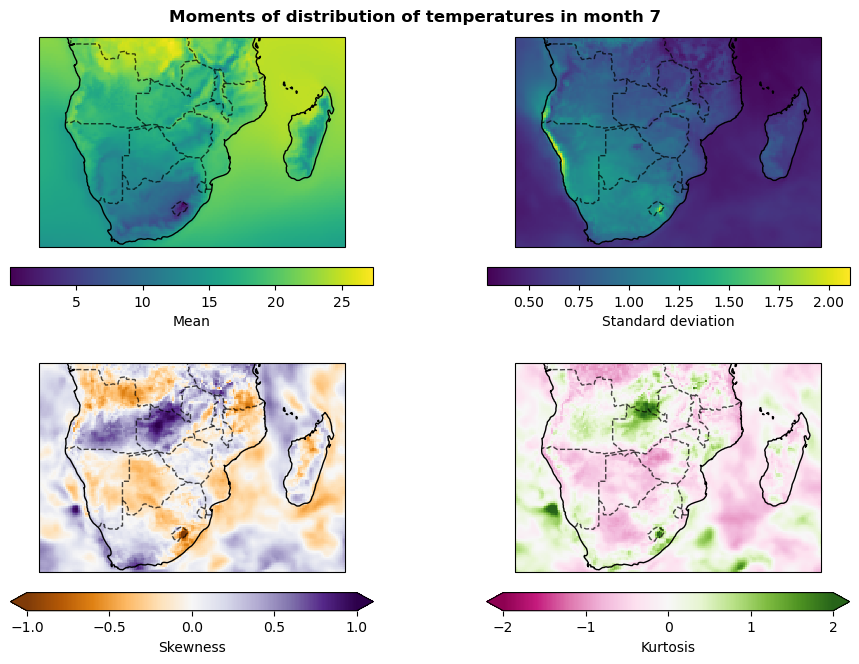

In [71]:
era5_m = t2m.groupby("time.month")[7]

# check distribution of residuals
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 7), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05, hspace = 0.275, top = 0.94)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.8, "pad" : 0.08}
axs = fig.axes
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
era5_m.mean("time").plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : "Mean"})
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
era5_m.std("time").plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : "Standard deviation"})
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
cbar = ax.pcolormesh(era5_m.lon, era5_m.lat, skew(era5_m, axis = 0), vmin = -1, vmax = 1, cmap = "PuOr")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Skewness", extend = "both")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[3]
cbar = ax.pcolormesh(era5_m.lon, era5_m.lat, kurtosis(era5_m, axis = 0), vmin = -2, vmax = 2, cmap = "PiYG")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Kurtosis", extend = "both")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
    
plt.suptitle("Moments of distribution of temperatures in month "+str(m), fontweight = "bold")


Text(0.5, 0.98, 'Results of KS test for normality of monthly mean temperatures')

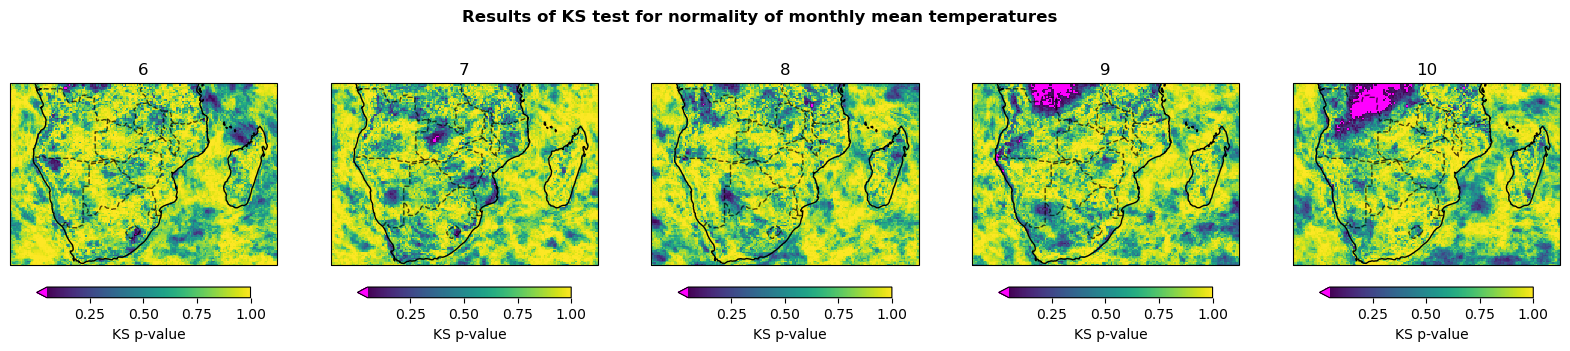

In [84]:
# see if monthly temperatures could plausibly be from a standard normal distribution

fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 3.5), dpi = 100, subplot_kw = {"projection" : cproj})
ks_cmap = matplotlib.cm.viridis; ks_cmap.set_under('magenta')

for i in range(5):
    ax = axs[i]
    era5_m = t2m.groupby("time.month")[i+6]
    era5_m = (era5_m - era5_m.mean("time")) / era5_m.std("time")
    
    ks_res = xr.apply_ufunc(lambda x : list(kstest(x, cdf = norm.cdf))[1], era5_m, vectorize = True, input_core_dims = [["time"]])
    
    cbar = ax.pcolormesh(era5_m.lon, era5_m.lat, ks_res, vmin = 0.05, vmax = 1, cmap = ks_cmap)
    plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "KS p-value", extend = "min")

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
    ax.set_title(str(i+6))
    
#     ax.gridlines(color = "k", alpha = 0.3, draw_labels = ["bottom"])
    
# axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"])
plt.suptitle("Results of KS test for normality of monthly mean temperatures", fontweight = "bold")
# plt.savefig("fig/ks-test-for-normality.png")

## **Fit linear model**

In [2]:
# load covariates: where data is not yet available, assume persistence (in practice, only applies to October 2023)
gmst = decode_times(xr.open_dataset("igiss_al_gl_a_4yrlo.nc", decode_times = False)).Ta.sel(time = slice("1950", "2023"))
nino34rel = decode_times(xr.open_dataset("iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023")).ffill("time")
dmi = decode_times(xr.open_dataset("idmi_ersst.nc", decode_times = False))["diff"].sel(time = slice("1950", "2023")).ffill("time")

In [3]:
t2m = decode_times(xr.open_dataset("era5_t2m_daily_af_extended_8-52E_-35--5N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_30.nc", decode_times = False)).t2m.dropna("time", "all")
lsm = xr.open_dataset("era5_000000_lsm_af.nc").lsm.squeeze(drop = True).rename(latitude = "lat", longitude = "lon")
t2m = t2m.where(lsm >= 0.5)

In [4]:
# define method to fit linear model using least squares & extract coeffs, p-values & residuals 
def lm_fit(Y): 
    
    if any(np.isnan(Y)):
        return(np.array([np.nan] * (4 + 4 + len(Y))))

    X = np.column_stack([xr.ones_like(gmst).values, gmst.values, nino34rel.groupby("time.month")[m].values, dmi.groupby("time.month")[m].values])
    lm = sm.OLS(Y,X).fit()
    
    return(np.array(list(lm.summary2().tables[1]['Coef.']) + list(lm.summary2().tables[1]['P>|t|']) + list(lm.resid)))

In [5]:
coeffs = []
pvals = []
residuals = []

for m in range(6,11):
    
    era5_m = t2m.groupby("time.month")[m]

    # chancing it with fitting in Python
    X = np.column_stack([xr.ones_like(gmst).values, gmst.values, nino34rel.groupby("time.month")[m].values, dmi.groupby("time.month")[m].values])
    Y = era5_m.isel(lon = 30, lat = 0).values

    linear_fit = xr.apply_ufunc(lm_fit, era5_m, vectorize = True, input_core_dims = [["time"]], output_core_dims = [["res"]])

    coeffs.append(linear_fit.isel(res = slice(0,4)).rename(res = "coeff").assign_coords(coeff = ["mu0", "gmst", "nino34rel", "iod"]).expand_dims(month = [m]))
    pvals.append(linear_fit.isel(res = slice(4,8)).rename(res = "coeff").assign_coords(coeff = ["mu0", "gmst", "nino34rel", "iod"]).expand_dims(month = [m]))
    residuals.append(linear_fit.isel(res = slice(8,None)).rename(res = "time").assign_coords(time = era5_m.time))

In [10]:
coeffs = xr.concat(coeffs, "month"); coeffs.to_netcdf("linear-fit_coeffs.nc")
pvals = xr.concat(pvals, "month"); pvals.to_netcdf("linear-fit_pvals.nc")
residuals = xr.concat(residuals, "time").sortby("time"); residuals.to_netcdf("linear-fit_residuals.nc")

### **Parameter maps**

In [11]:
cbar_kwargs = {"location" : "bottom", "fraction" : 0.075, "shrink" : 0.8, "pad" : 0.08}

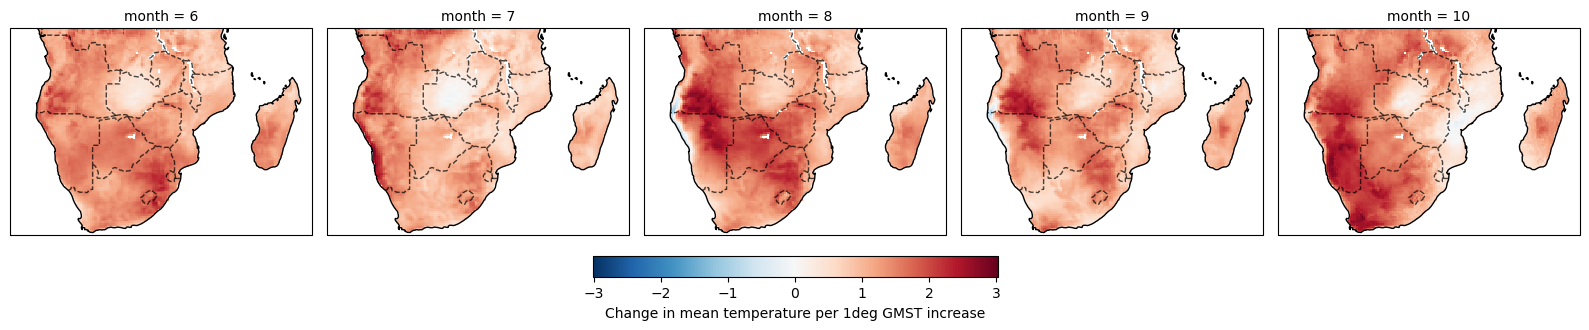

In [156]:
coeffs.sel(coeff = "gmst").plot(col = "month", subplot_kws = {"projection" : cproj}, cbar_kwargs = cbar_kwargs | {"label" : "Change in mean temperature per 1deg GMST increase"})
for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
plt.savefig("fig/coef_gmst.png")

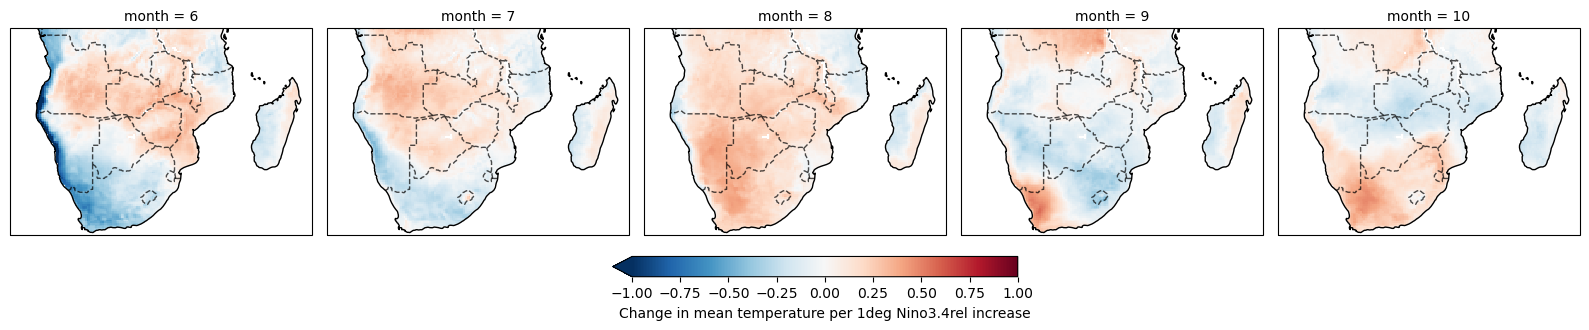

In [154]:
coeffs.sel(coeff = "nino34rel").plot(col = "month", subplot_kws = {"projection" : cproj}, cbar_kwargs = cbar_kwargs | {"label" : "Change in mean temperature per 1deg Nino3.4rel increase"}, 
                                     vmin = -1, vmax = 1, cmap = "RdBu_r")
for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
plt.savefig("fig/coef_nino.png")

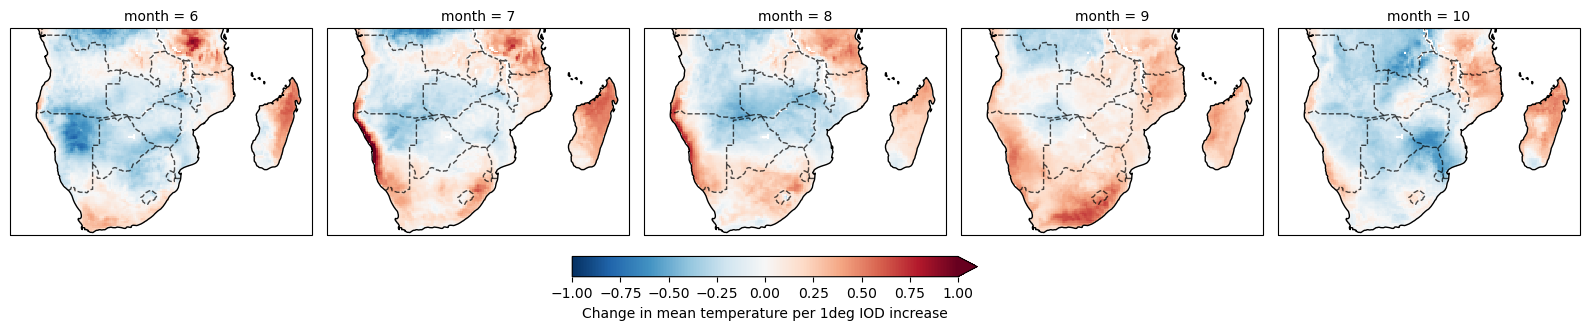

In [155]:
coeffs.sel(coeff = "iod").plot(col = "month", subplot_kws = {"projection" : cproj}, cbar_kwargs = cbar_kwargs | {"label" : "Change in mean temperature per 1deg IOD increase"}, 
                               vmin = -1, vmax = 1, cmap = "RdBu_r")
for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
plt.savefig("fig/coef_iod.png")

### **Normality of residuals**

In [54]:
# test normality of standardised residuals
sres = residuals.groupby("time.month") / residuals.groupby("time.month").std()

In [56]:
residual_kstest = xr.concat([xr.apply_ufunc(lambda x : list(kstest(x, cdf = norm.cdf))[1], sres.groupby("time.month")[m], vectorize = True, input_core_dims = [["time"]]) for m in range(6,11)], "month")
residual_kstest = residual_kstest.assign_coords(month = range(6,11))

Text(0.5, 0.98, 'Results of KS test for normality of residuals from linear model\n(pink denotes significant evidence of non-normality)')

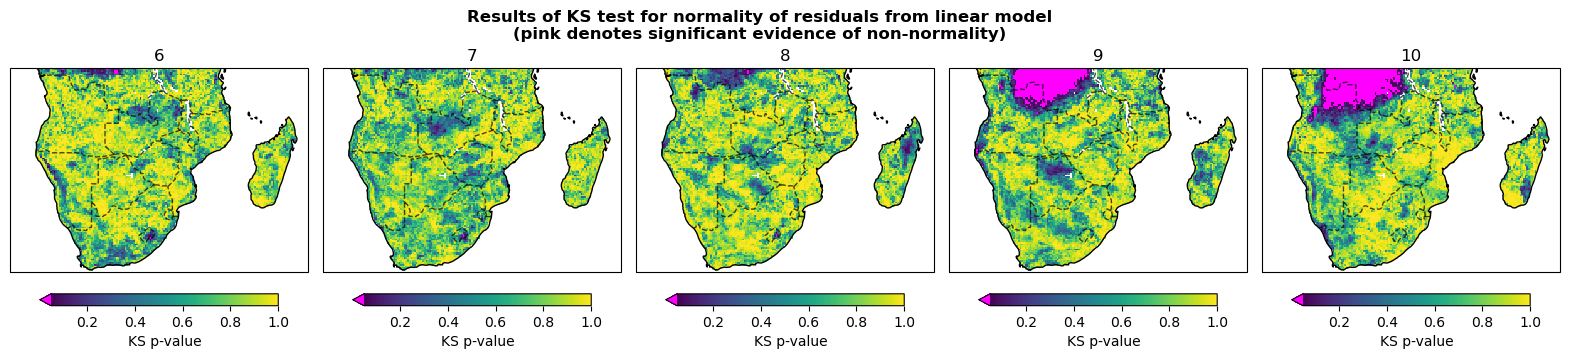

In [57]:
fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 3.5), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05)
ks_cmap = matplotlib.cm.viridis; ks_cmap.set_under('magenta')

for i in range(5):
    ax = axs[i]
    
    cbar = ax.pcolormesh(residual_kstest.lon, residual_kstest.lat, residual_kstest.sel(month = i+6), vmin = 0.05, vmax = 1, cmap = ks_cmap)
    plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "KS p-value", extend = "min")

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
    ax.set_title(str(i+6))
    
#     ax.gridlines(color = "k", alpha = 0.3, draw_labels = ["bottom"])
    
# axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"])
plt.suptitle("Results of KS test for normality of residuals from linear model\n(pink denotes significant evidence of non-normality)", fontweight = "bold")
# plt.savefig("fig/ks-test-for-normality.png")

Text(0.5, 0.98, 'Skewness of residuals from linear model')

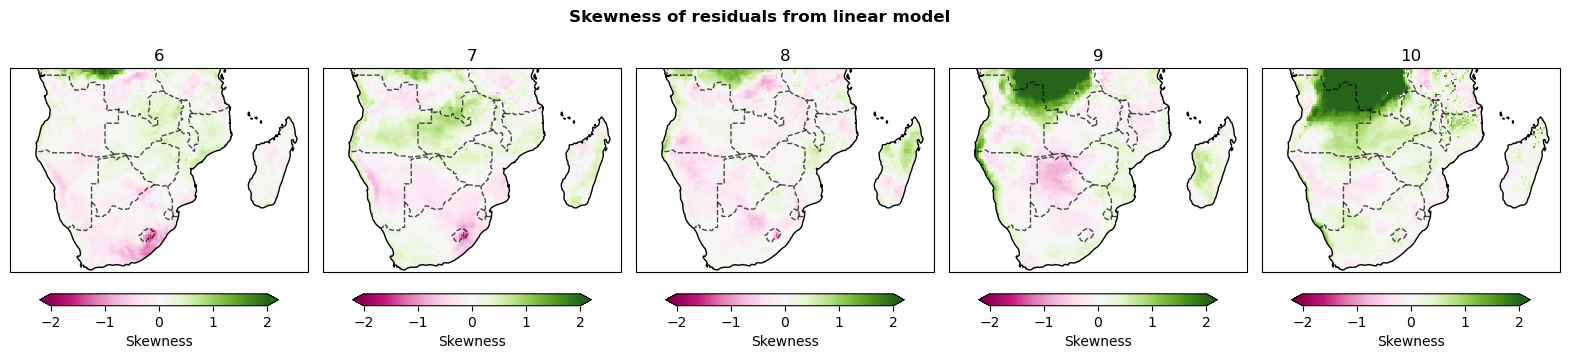

In [62]:
# what's the reason for the non-normality? Kurtosis or skewness?
fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 3.5), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05)
ks_cmap = matplotlib.cm.viridis; ks_cmap.set_under('magenta')

for i in range(5):
    ax = axs[i]
    
    cbar = ax.pcolormesh(sres.lon, sres.lat, skew(sres.groupby("time.month")[i+6].transpose("time", ...)), vmin = -2, vmax = 2, cmap = "PiYG")
    plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Skewness", extend = "both")

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
    ax.set_title(str(i+6))
    
#     ax.gridlines(color = "k", alpha = 0.3, draw_labels = ["bottom"])
    
# axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"])
plt.suptitle("Skewness of residuals from linear model", fontweight = "bold")
# plt.savefig("fig/ks-test-for-normality.png")

Text(0.5, 0.98, 'Kurtosis of residuals from linear model')

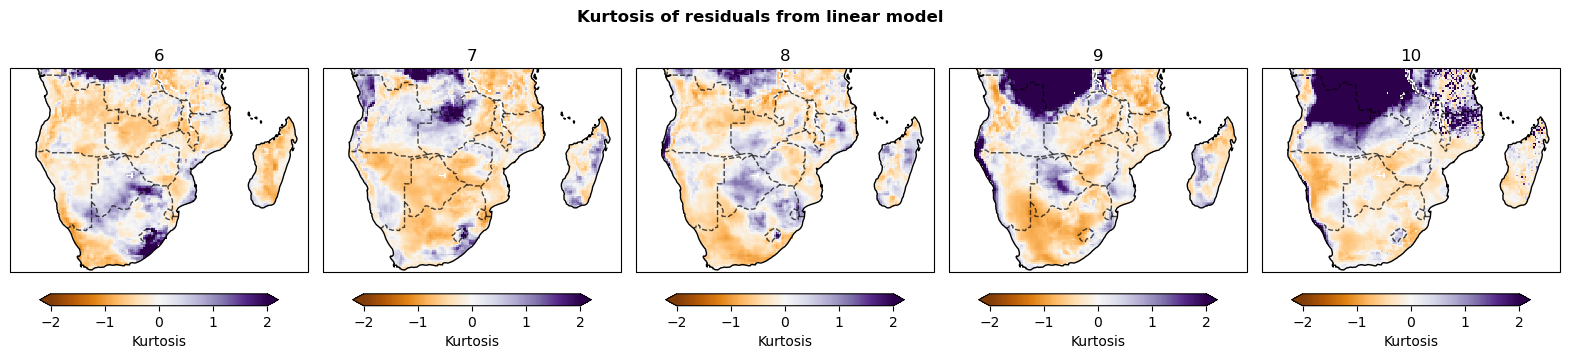

In [60]:
# what's the reason for the non-normality? Kurtosis or skewness?
fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 3.5), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05)
ks_cmap = matplotlib.cm.viridis; ks_cmap.set_under('magenta')

for i in range(5):
    ax = axs[i]
    
    cbar = ax.pcolormesh(sres.lon, sres.lat, kurtosis(sres.groupby("time.month")[i+6].transpose("time", ...)), vmin = -2, vmax = 2, cmap = "PuOr")
    plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Kurtosis", extend = "both")

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
    ax.set_title(str(i+6))
    
#     ax.gridlines(color = "k", alpha = 0.3, draw_labels = ["bottom"])
    
# axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"])
plt.suptitle("Kurtosis of residuals from linear model", fontweight = "bold")
# plt.savefig("fig/ks-test-for-normality.png")

### **Return levels**

In [109]:
def rp(ts): return 1/norm.sf(ts.isel(time = -1), loc = ts.mean("time"), scale = ts.std("time"))

In [110]:
rp(residuals.groupby("time.month")[6])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

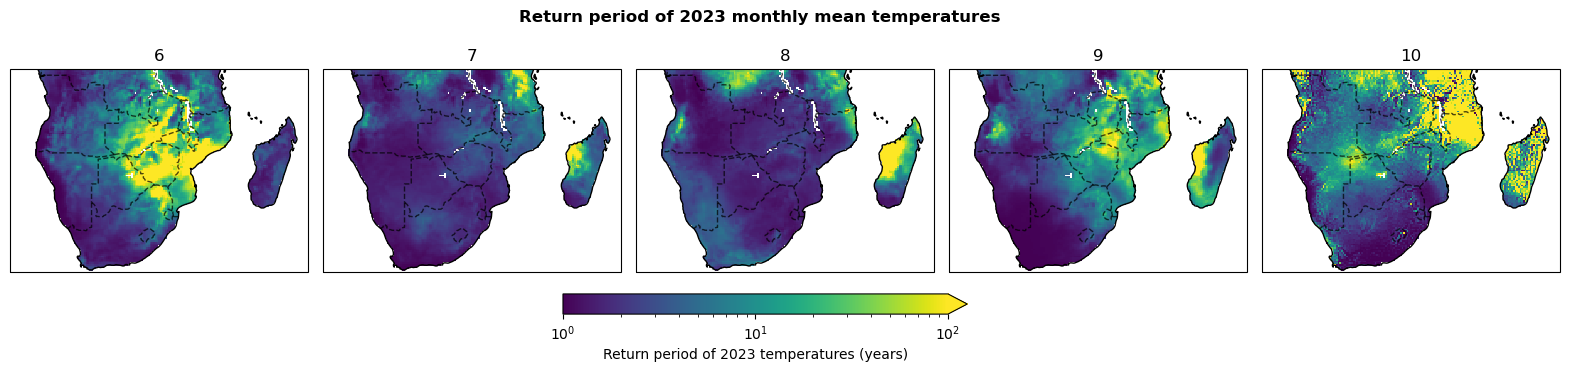

In [151]:
fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 3.5), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05)

for i in range(5):
    ax = axs[i]
    m = i+6
    
    cbar = ax.pcolormesh(residuals.lon, residuals.lat, rp(residuals.groupby("time.month")[m]), cmap = "viridis", norm=matplotlib.colors.LogNorm(vmin = 1, vmax = 100))
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
    ax.set_title(str(i+6))
    
cbar = plt.colorbar(cbar, ax = axs, **cbar_kwargs, label = "Return period of 2023 temperatures (years)", extend = "max")
# cbar.ax.set_xticklabels(["", "", 1,10,100,1000,10000])

# axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"])
plt.suptitle("Return period of 2023 monthly mean temperatures", fontweight = "bold")
plt.savefig("fig/return-period-from-linear-model.png")

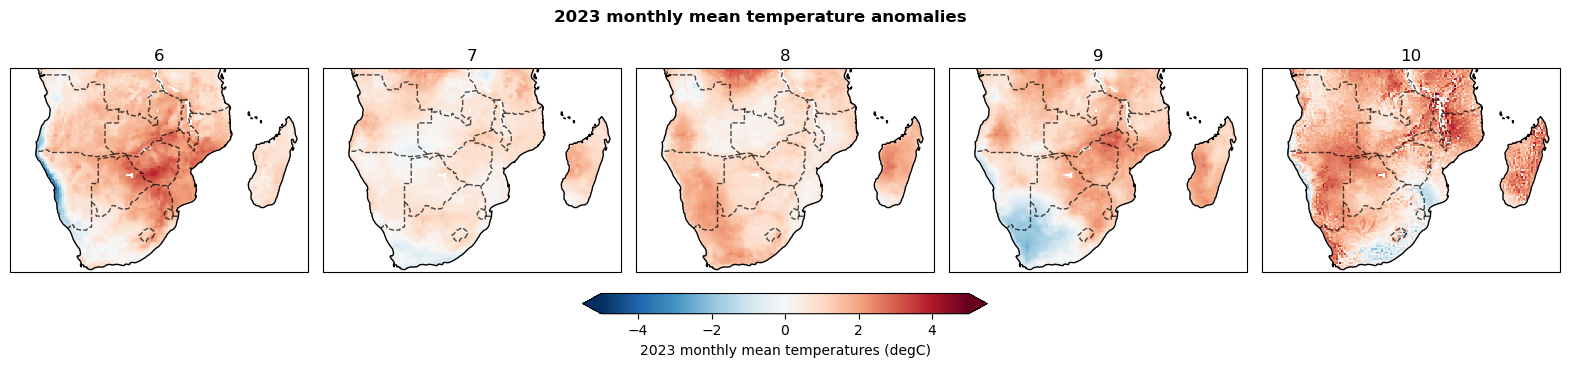

In [152]:
fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 3.5), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05)

for i in range(5):
    ax = axs[i]
    m = i+6
    
    cbar = (t2m.sel(time = "2023-"+str(m)).squeeze(drop = True) - t2m.groupby("time.month")[m].mean("time")).plot(ax = ax, add_colorbar = False, cmap = "RdBu_r", vmin = -5, vmax = 5)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
    ax.set_title(str(i+6))
    
cbar = plt.colorbar(cbar, ax = axs, **cbar_kwargs, label = "2023 monthly mean temperatures (degC)", extend = "both")

# axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"])
plt.suptitle("2023 monthly mean temperature anomalies", fontweight = "bold")
plt.savefig("fig/2023-tmean-anomaly.png")

## **Compare model fits**

In [2]:
# load covariates: where data is not yet available, assume persistence (in practice, only applies to October 2023)
gmst = decode_times(xr.open_dataset("igiss_al_gl_a_4yrlo.nc", decode_times = False)).Ta.sel(time = slice("1950", "2023"))
nino34rel = decode_times(xr.open_dataset("iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023")).ffill("time")
dmi = decode_times(xr.open_dataset("idmi_ersst.nc", decode_times = False))["diff"].sel(time = slice("1950", "2023")).ffill("time")

In [16]:
t2m = decode_times(xr.open_dataset("era5_t2m_daily_af_extended_8-52E_-35--5N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_30.nc", decode_times = False)).t2m.dropna("time", "all")
lsm = xr.open_dataset("era5_000000_lsm_af.nc").lsm.squeeze(drop = True).rename(latitude = "lat", longitude = "lon")
t2m = t2m.where(lsm >= 0.5)

In [31]:
# define method to fit linear model using least squares & extract coeffs, p-values & residuals 
def lm_fit(Y): 
    
    if any(np.isnan(Y)):
        return(np.array([np.nan] * (4 + 4 + len(Y))))

    lm = sm.OLS(Y,X).fit()
    
    return(np.array(list(lm.summary2().tables[1]['Coef.']) + list(lm.summary2().tables[1]['P>|t|']) + list(lm.resid)))

In [12]:
coeffs = []
pvals = []
residuals = []

covars = ["gmst"]

In [5]:
for m in range(6,11):
    
    era5_m = t2m.groupby("time.month")[m]

    # chancing it with fitting in Python
    X = np.column_stack([xr.ones_like(gmst).values, gmst.values, nino34rel.groupby("time.month")[m].values, dmi.groupby("time.month")[m].values])
    X = X[:,[["const", "gmst", "nino34", "iod"].index(v) for v in ["const"] + covars]]
    
    linear_fit = xr.apply_ufunc(lm_fit, era5_m, X, vectorize = True, input_core_dims = [["time"]], output_core_dims = [["res"]])

    coeffs.append(linear_fit.isel(res = slice(0,4)).rename(res = "coeff").assign_coords(coeff = ["mu0", "gmst", "nino34rel", "iod"]).expand_dims(month = [m]))
    pvals.append(linear_fit.isel(res = slice(4,8)).rename(res = "coeff").assign_coords(coeff = ["mu0", "gmst", "nino34rel", "iod"]).expand_dims(month = [m]))
    residuals.append(linear_fit.isel(res = slice(8,None)).rename(res = "time").assign_coords(time = era5_m.time))

In [10]:
coeffs = xr.concat(coeffs, "month"); coeffs.to_netcdf("linear-fit_coeffs.nc")
pvals = xr.concat(pvals, "month"); pvals.to_netcdf("linear-fit_pvals.nc")
residuals = xr.concat(residuals, "time").sortby("time"); residuals.to_netcdf("linear-fit_residuals.nc")

In [32]:
X = np.column_stack([xr.ones_like(gmst).values, gmst.values, nino34rel.groupby("time.month")[m].values, dmi.groupby("time.month")[m].values])


In [17]:
era5_m = t2m.groupby("time.month")[m]

# chancing it with fitting in Python
X = np.column_stack([xr.ones_like(gmst).values, gmst.values, nino34rel.groupby("time.month")[m].values, dmi.groupby("time.month")[m].values])
X = X[:,[["const", "gmst", "nino34", "iod"].index(v) for v in ["const"] + covars]]

In [33]:
linear_fit = xr.apply_ufunc(lm_fit, era5_m, vectorize = True, input_core_dims = [["time"]], output_core_dims = [["res"]])

KeyboardInterrupt: 